---

# Image Contrast Enhancement

Falk Mielke, FunMorph, Universiteit Antwerpen

---

You can download this notebook [here](user://notebooks/ImageContrast.ipynb?download&target=_blank).


When recording biplanar x-ray video data, one has to manually choose the exposure of every x-ray source. 

At least, we had to, in our fabulous [3D²YMOX setup](https://www.uantwerpen.be/en/research-groups/3d2ymox/?target=_blank) for my piglet experiments.

The problem is that limbs and body of our subject animals have different thickness, and in consequence the cumulated x-ray absorbtion differs. Therefore, it is challenging to  choose an exposure that allows the simultaneous visualization of limbs and the main body. Because our project is about locomotion, we decided rather intuitively to select an exposure that would resolve the limbs well.


Here is an example image:


<img src="images/xcam1_preview.png" width=512 height=512>

I find x-ray images like this one beautiful, especially as a video sequence. Distal limb long bones are particularly visible. However, when it comes to quantitative analysis, tracking a point at the edges of the field of view might be challenging. Similarly, when limbs overlap, or when considering the humerus, [point tracking](../tracking?target=_blank) would be more speculation than science. 


Luckily, these images contain more information than meets the eye. There are $2^{12}$ possible gray values in there (our setup stores 12 bit raw images), and one can apply image manipulations to improve contrast in a certain range of gray. 
Several software tools exist for this task.
One immediate challenge is that, instead of only one image, I require thousands of them as a high speed video frame sequence.

**NB:** Here and below, I only talk about uniform, scientific image manipulations. This tutorial is not about what is colloquially called "photoshopping" something into something which is not real. 


One software tool to perform such image manipulations is manual image manipulation, for example in [GIMP](https://gimp.org/?target=_blank). 
GIMP is even scriptable, so modifications can be batch applied to a video frame sequence. 
An alternative is [darktable](https://www.darktable.org/?target=_blank), a photo effect application suite. In darktable, one can play around, then store a history of manipulation steps as preset, and apply it to other images.


Those are really nice programs, and I have used them repeatedly. But because I have to manage many folders (multiple cameras, many recordings per subject), and because I have an affiliation for python, I went for an even more scalable solution. 


What I demonstrate below is applied to grayscale images. It should work equally for color images, either if the functions apply directly, or by splitting the color channels.

## Python Image Manipulation

Image manipulation is a task required by many fields. Consequently, image manipulation libraries are commonplace.

There are three libraries which I frequently use:
- The [SciPy ecosystem](https://scipy.org/?target=_blank), with [`numpy`](https://numpy.org/?target=_blank), [`matplotlib`](https://matplotlib.org?target=_blank) and [`scipy.ndimage`](https://docs.scipy.org/doc/scipy/reference/ndimage.html?target=_blank).
- [openCV](https://opencv.org?target=_blank) (mostly for direct video processing, i.e. streaming)
- [scikit image](https://scikit-image.org?target=_blank)

All of them have useful features, and I will only mention a few highlights in this post which have facilitated my work. Some might load images better than others, but usually formats are interconvertible.
With non-standard image formats (like my 12 bit tifs), it is good to try if/how all of them load images into memory. 

The rule here: if you manage to load an image and convert it to a `numpy` float array, you're in charge!


First, let's load these and other libraries.

In [1]:
import numpy as NP
import pandas as PD
import scipy.ndimage as NDI
import matplotlib as MP
import matplotlib.pyplot as MPP

import skimage as SKI
from skimage import io as SKIO
# import cv2 as CV


%matplotlib inline


def LoadImageFloat(filename, bits = 0):
    # image loading with bit conversion
    img = MPP.imread(filename) / 2**bits
    
    ## alternative:
    # img = SKI.img_as_float(SKIO.imread(filename)) / 2**bits

    return img


### remove axis labels from a matplotlib axis
def FullDespine(ax):

    ax.get_xaxis().set_tick_params(which='none')
    ax.get_yaxis().set_tick_params(which='none')
    ax.get_xaxis().set_tick_params(which='both', direction='out')
    ax.get_yaxis().set_tick_params(which='both', direction='out')

    ax.tick_params(top=False)
    ax.tick_params(right=False)
    ax.tick_params(left=False)
    ax.tick_params(right=False)

    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_xticks([])
    ax.set_yticks([])

    
def ConvertBits12to16(file_in, file_out):
    img = MPP.imread(file_in) / 2**12
    img = NP.array((img)*(2**16), dtype = NP.uint16)
    SKIO.imsave(file_out, img)


It will also be useful to have a function that plots a list of images for comparison.

In [2]:
def ImageComparison(  image_list, n_cols = 4, dpi = 300, plot_args = dict(cmap = 'gray') \
                    , show_histogram = False, titles = None):
    ### plot multiple images side by side
    
    ## layout
    n_rows = (len(image_list)-1) // n_cols + 1
    n_cols = NP.min([len(image_list), n_cols])
    height_ratios = [1, 0.2]*n_rows if show_histogram else [1]*n_rows
    width_ratios = [1]*n_cols
    
    ## figure preparation
    cm = 1/2.54 # inch to cm conversion
    figwidth = 10 * cm
    fig = MPP.figure(  dpi = dpi \
                     , figsize = (figwidth, figwidth * NP.sum(height_ratios) / NP.sum(width_ratios) ) \
                     , facecolor = 'w')
    fig.subplots_adjust( \
                          top    = 1. \
                        , right  = 1. \
                        , bottom = 0. \
                        , left   = 0. \
                        , wspace = 0.00 # column spacing \
                        , hspace = 0.00 # row spacing \
                        )
    
    ## grid of images
    grid = MP.gridspec.GridSpec( \
                              n_rows * (2 if show_histogram else 1) \
                            , n_cols \
                            , height_ratios = height_ratios \
                            , width_ratios = width_ratios \
                            )
    
    ## plot images:
    for grid_idx, img in enumerate(image_list):
        col = (grid_idx) % n_cols
        row = (grid_idx // n_cols) * (2 if show_histogram else 1)

        
        ax = fig.add_subplot(grid[row, col], aspect = 'equal')
        
        ax.imshow(img, **plot_args)
        
        FullDespine(ax)

        if titles is not None:
            ax.set_title(titles[grid_idx], fontsize = 8)
        
        if show_histogram:
            # optionally show the histogram below the image
            ax = fig.add_subplot(grid[row+1, col], frameon=True, facecolor = (0.9,0.9,0.9))
            heights, _, _ = ax.hist(  img.ravel(), bins = 2**8 \
                                    , histtype='stepfilled', color= (0.2, 0.2, 0.6) \
                                    , density = True \
                                   )
            ax.set_ylim(NP.percentile(heights, [0, 98])*1.05)
            
            ax.set_xlim([0., 1.])
            FullDespine(ax)
        
    MPP.show();

In [3]:
img1 = LoadImageFloat('hs4.tif', bits = 16)
img2 = LoadImageFloat('hs4_improved.tif', bits = 16)

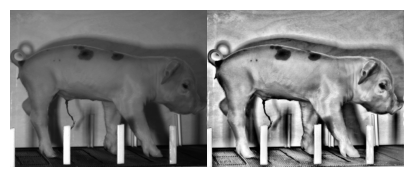

In [4]:
ImageComparison([img1, img2], dpi = 100)

There are a couple more functions that I use for histogram modification.

In [5]:

def Normalize(img):
    ### spread an image histogram over the bit range
    # print (NP.amin(img), NP.amax(img))
    img = img.copy()

    img = img - NP.amin(img) 
    img = img / NP.amax(img)
    # img = img % 1

    return img


def HistogramCut(img, shift = 0., cap = 1.):
    ### restrict the histogram to a rante between 'shift' and 'cap' 
    ## should be between 0. and 1., with shift < cap 
    img = img.copy()
    img[img>cap] = cap

    img -= shift
    img[img<0] = 0.

    img /= (cap-shift)

    return img


In [6]:
# example:
img1 = Normalize(img1.copy())
img1 = HistogramCut(img1.copy(), shift = 0.0, cap = 0.8)

These functions work on the *histogram* of the image.
The histogram shows which values withing the bit range of an image (black to white shades in a grayscale image) are present how often.

Let's briefly see the histogram for the test image:




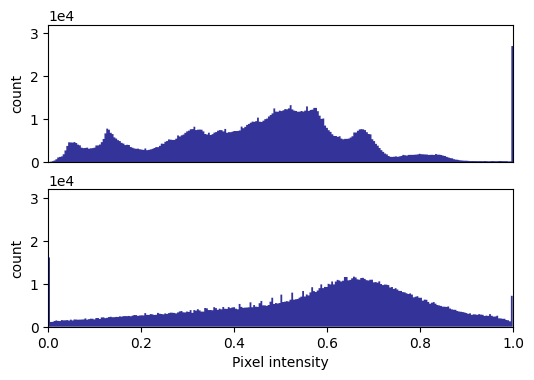

In [7]:
# Display histogram
fig = MPP.figure(dpi = 100, facecolor = 'w')

for nr, img in enumerate([img1, img2]):
    ax = fig.add_subplot(2,1,nr+1)
    ax.hist(img.ravel(), bins = 2**8, histtype='stepfilled', color= (0.2, 0.2, 0.6), density = False)
    ax.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    if nr == 1:
        ax.set_xlabel('Pixel intensity')
    
    else:
        ax.get_xaxis().set_visible(False)
    ax.set_ylabel('count')
    ax.set_ylim([0, 32000])
    ax.set_xlim(0., 1.)
MPP.show();

You have certainly seen histograms like these in image manipulation software or photo camera displays.

With this in place, let's go manipulate images (in a good way)!

# A Series of Manipulation Steps

Let's start over with a raw, 12bit x-ray image.
Note that I `.copy()` the images a lot, because otherwise the original `numpy` array is manipulated by downstream operations (and even with deep copies, there seems to be trouble sometimes). 

In [8]:
img_raw = NP.flipud(LoadImageFloat('xcam1.tif', bits = 12))

image_chain = {'raw': img_raw.copy()}
img_current = img_raw.copy()

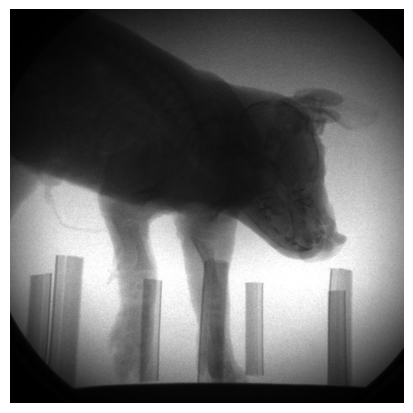

In [9]:
ImageComparison([img_raw], dpi = 100)

## Edges

Typical image landmarks lay on edges, or even better intersections of edges.

A classical way to find edges is by blurring the image and subtracting the blurred from the original image. Fine tuning of the blurring degree is advisible.

In [10]:
img_current = Normalize(SKI.exposure.adjust_log(img_raw.copy(), gain = 1., inv = False)) # explained below
blurred_image = NDI.filters.gaussian_filter(img_current, 32.)
edges = NP.subtract(img_current, blurred_image) / 2. + 0.5

##optional: add edges
edge_factor = 0.9
img_edged = Normalize(NP.add(img_current, edge_factor*edges)/(1.+edge_factor))

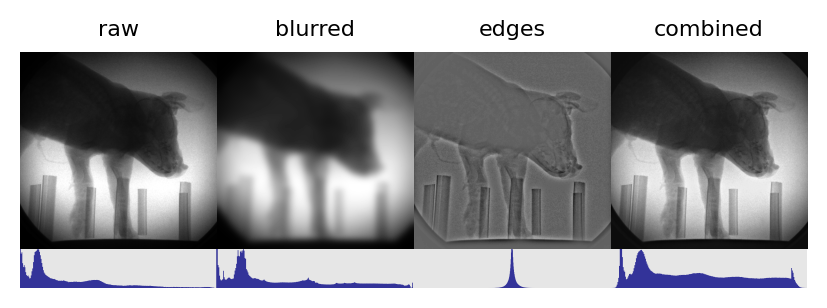

In [11]:
ImageComparison([image_chain['raw'], blurred_image, edges, img_edged], dpi = 200 \
                , show_histogram = True, titles = ['raw', 'blurred', 'edges', 'combined'])

In [12]:
img_current = img_edged.copy()
image_chain['edges'] = img_current

Finding a right mix between raw image and edges, this can in some cases help to add some contrast to just the right spots on your image.

Note that more sophisticated edge detection- and other algorithms exists, [see here](https://scikit-image.org/docs/dev/auto_examples/index.html?target=_blank) [and here](https://scikit-image.org/docs/dev/auto_examples/edges/plot_edge_filter.html?target=_blank) for examples.



Two related improvements are the use of differential images over time (i.e. difference of two consecutive frames to visualize only moving parts), and the use of "empty" scene shots to remove background.

## Histogram Equalization

Another set of useful tools can be [found in the skimage docs](https://scikit-image.org/docs/dev/auto_examples/index.html#manipulating-exposure-and-color-channels). 

For example, let's log adjust the exposure of our x-ray example image.

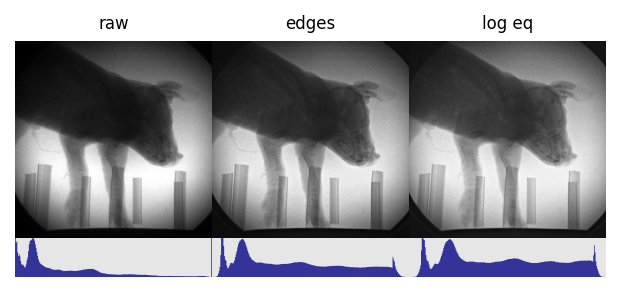

In [13]:
img_current = Normalize(SKI.exposure.adjust_log(img_current.copy(), gain = 4., inv = False))

image_chain['log eq'] = img_current.copy()
titles = ['raw', 'edges', 'log eq']
ImageComparison([image_chain[selection] for selection in titles], dpi = 150 \
                , show_histogram = True, titles = titles)

Though hardly visible, the image is slightly more balanced in the "mid" intensities.

Even more powerful, but also potentially more severe, than a global histogram equalization is *adaptive* histogram equalization. This takes local patches of the image and normalizes therein.

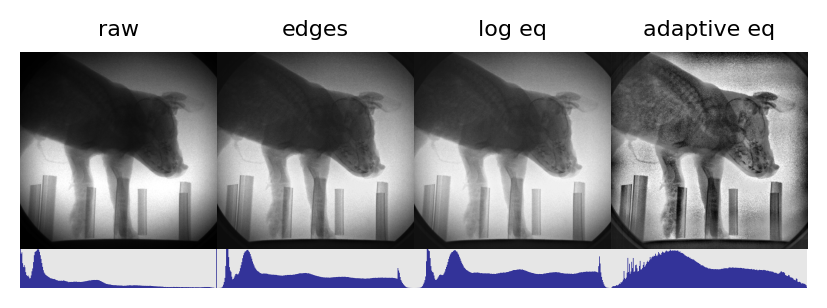

In [14]:
img_adapteq = SKI.exposure.equalize_adapthist(  img_current.copy() \
                                              #, kernel_size = 16**2
                                              #, nbins = 2**16 \
                                              , clip_limit = 0.02 \
                                             )
img_adapteq = Normalize(img_adapteq)
ImageComparison([image_chain[selection] for selection in titles] + [img_adapteq], dpi = 200 \
                , show_histogram = True, titles = titles + ['adaptive eq'])

Usually, it is sufficient to modify the `clip_limit` parameter of the function. The other two are quite well inferred from image dimensions by the `skimage` algorithm.

Note that artefacts of the equalization patches can become visible. However, with the right settings, adaptive equalization can drastically improve the visibility of relevant features, such as bones on the xray images.

Once the settings are fine-tuned, the image can be added to our display chain.

In [15]:
image_chain['adaptive eq'] = SKI.img_as_float(img_adapteq).copy()

## Finishing the image

These are just examples of possible contrast improvement, in an environment that is almost ready to be rolled out to all your images.

In my actual data, I still add a couple of tweaks, namely combining edges and the equalized image, equalizing again, normalizing, and cutting the histogram. 


In [16]:
img_final = img_adapteq.copy()


# another global equalization
img_final = SKI.exposure.adjust_log(img_final, gain = 1., inv = False)

# cut the histogram
img_final = HistogramCut(img_final, 0.08, 0.98)
img_final = Normalize(img_final)

image_chain['final'] = img_final.copy()

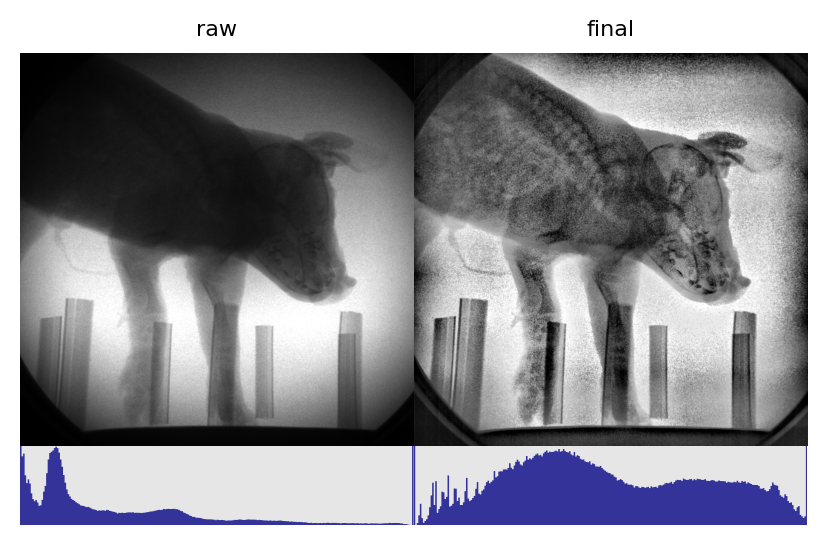

In [17]:
ImageComparison([img_raw, img_final], dpi = 200 \
                , show_histogram = True, titles =  ['raw', 'final'])

Whereas the limb bones are equally visible as before, structures within the body of the subject animal (e.g. vertebrae, proximal humerus) become highlighted by this procedure.

# Application to Light Camera Images

This is not only useful for x-ray images. We also keep light camera recordings of three highspeed cameras (which are relatively few for 3D kinematic measurements).

It is hard to balance lighting of the entire setup for all cameras, also because too intense lights can be aversive for animals. Natural shadows on the recorded images will complicate tracking.

The algorithms provided above can lead to a more uniform lighting of such images.


Let's collect our adjustment steps in a single function:

In [18]:
def DefaultImageManipulation(img_raw, edge_factor = 0., adaptive_eq_args = None):
    
    # initial equalization
    img = Normalize(SKI.exposure.adjust_log(img_raw.copy(), gain = 1., inv = False))
    
    # edge amplification
    blurred_image = NDI.filters.gaussian_filter(img, 32.)
    edges = Normalize(NP.subtract(img, blurred_image))

    img = Normalize(NP.add(img, edge_factor*edges)/(1.+edge_factor))
    
    # second equalization
    img = Normalize(SKI.exposure.adjust_log(img, gain = 4., inv = False))
        
    # adaptive equalization
    if adaptive_eq_args is not None:
        img = SKI.exposure.equalize_adapthist( img.copy(), **adaptive_eq_args )
    
    # another global equalization
    img = SKI.exposure.adjust_log(img, gain = 1., inv = False)

    # cut the histogram
    img = HistogramCut(img, 0.08, 0.98)
    img = HistogramCut(Normalize(img))
    
    
    return img


This function can easily be applied to images:

In [19]:
img_raw = LoadImageFloat('hs4.tif', bits = 16)
img_plain = DefaultImageManipulation(img_raw.copy(), edge_factor = 1.0 \
                                     , adaptive_eq_args = None)
img_adaptive = DefaultImageManipulation(img_raw.copy(), edge_factor = 1.0 \
                                     , adaptive_eq_args = dict(clip_limit = 0.02))

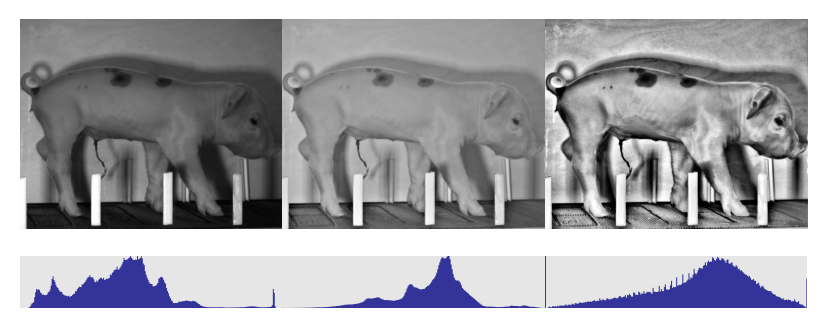

In [20]:
ImageComparison([img_raw, img_plain, img_adaptive], dpi = 200 \
                , show_histogram = True)

In [21]:
# saving the result:
img = NP.array((img_adaptive*0.999)*(2**16), dtype = NP.uint16)
SKIO.imsave('hs4_improved.tif', img)

Note that the adaptive equalization in this case can highlight muscles and bones that define the outer shape of the animal. So you might want to attempt this on your holiday photos.

The `DefaultImageManipulation` function can be easily applied to a set of files with python, using `OS.listdir` and a loop.

---

# Summary

Few images are acquired in studio-like photo settings, which can complicate scientific analysis. 

Above, I collected a few tricks how to improve contrast on such images ex post. 
The enhanced images have many crucial features exposed, which makes them available for point tracking. 

Because the tools mentioned herein are fully available in python, it is trivial to apply them to collections of photos. 

I hope you enjoyed this demonstration and find use for such image manipulation for your own data!